In [2]:
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix
import sys 
import matplotlib.lines as mlines
import pyforest
import sys
sys.path.append('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/')
# from updated_RF import *
from RF_functions import *
from imblearn.over_sampling import SMOTEN, ADASYN, SMOTE
from sklearn.metrics import accuracy_score, balanced_accuracy_score,precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score, confusion_matrix,matthews_corrcoef
from matplotlib.lines import Line2D
from rdkit import Chem
from rdkit.Chem import AllChem

import os
import pickle
import shutil
import scipy as sp
from sklearn.metrics import pairwise_distances


In [3]:

# ---------------------------------------------
def calc_AD_kmean_dist(train_dset, pred_dset, k, train_dset_pair_distance=None, dist_metric="euclidean"):
    """
    calculate the probability of the prediction dataset fall in the the domain of traning set. Use Euclidean distance of the K nearest neighbours.
    train_dset and pred_dset should be in 2D numpy array format where each row is a compound.
    """
    if train_dset_pair_distance is None:
        # calcualate the pairwise distance of training set
        train_dset_pair_distance = pairwise_distances(X=train_dset, metric=dist_metric)
    train_kmean_dis = []
    for i in range(len(train_dset_pair_distance)):
        kn_idx = np.argpartition(train_dset_pair_distance[i], k+1)
        dis = np.mean(train_dset_pair_distance[i][kn_idx[:k+1]])
        train_kmean_dis.append(dis)
    train_dset_distribution = sp.stats.norm.fit(train_kmean_dis)
    # pairwise distance between train and pred set
    pred_size = len(pred_dset)
    train_pred_dis = pairwise_distances(X=pred_dset, Y=train_dset, metric=dist_metric)
    pred_kmean_dis_score = np.zeros(pred_size)
    for i in range(pred_size):
        pred_km_dis = np.mean(np.sort(train_pred_dis[i])[:k])
        train_dset_std = train_dset_distribution[1] if train_dset_distribution[1] != 0 else 1e-6
        pred_kmean_dis_score[i] = max(1e-6, (pred_km_dis - train_dset_distribution[0]) / train_dset_std)
    return pred_kmean_dis_score

In [72]:
# neks = ['NEK2_binding', 'NEK2_inhibition','NEK3_binding', 'NEK5_binding', 'NEK9_binding','NEK9_inhibition']
GPpath= '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/GP_results/'
RFpath = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/results/RF_results/'
neks = ['NEK2_binding','NEK2_inhibition', 'NEK3_binding', 'NEK5_binding', 'NEK9_binding', 'NEK9_inhibition']
feat_types = ['MOE','MFP']
samplings = ['none_scaled', 'UNDER', 'SMOTE', 'ADASYN']
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

k=7
col_names = ['prediction_type', 'ADdist', 'model_type']
# model_palette = sns.color_palette("Set2", n_colors=3)
model_palette = sns.cubehelix_palette(start=.5, rot=-.5, n_colors=3)
category_order = ['TP', 'TN', 'FP', 'FN']
samp_palette={'no_samp': 'lightblue','UNDER':'orange', 'SMOTE':'hotpink'}
# samp_palette2={'orange':'UNDER', 'SMOTE':'hotpink', 'no_samp': 'lightblue'}

In [50]:
test1 = pd.read_csv('/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/datasets/80train_20test/featurized/NEK2_binding_MOE_none_scaled.csv')
test1.columns
remove_cols = ['NEK', 'compound_id', 'base_rdkit_smiles', 'subset', 'active'] 

In [21]:
nek_names = [] 
all_feats = [] 
sampling_types = [] 
test_dists = []

for nek in neks: 
    for feat in feat_types: 
        for samp in samplings: 
            df_path = f'/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/paper/datasets/80train_20test/featurized/'
            full_df = pd.read_csv(f'{df_path}{nek}_{feat}_{samp}.csv') 
            train_df = full_df[full_df['subset'] == 'train'].drop(columns=remove_cols)
            test_df = full_df[full_df['subset'] == 'test'].drop(columns=remove_cols)
            test_dist = calc_AD_kmean_dist(train_df, test_df, k)
            train_dist = calc_AD_kmean_dist(train_df, train_df, k)
            if samp == 'none_scaled': 
                adjusted_samp = 'no_samp'
            else:
                adjusted_samp = samp
            
            test_dists.append(test_dist) 
            nek_names.append(f'{nek}')
            all_feats.append(feat) 
            sampling_types.append(adjusted_samp)
            

In [22]:
AD_df = pd.DataFrame({'NEK': nek_names,'strategy': sampling_types, 'feat_type':all_feats,'ADdist':test_dists})
AD_df['dataset_category'] = AD_df['feat_type'].astype(str) + '_'+AD_df['strategy']


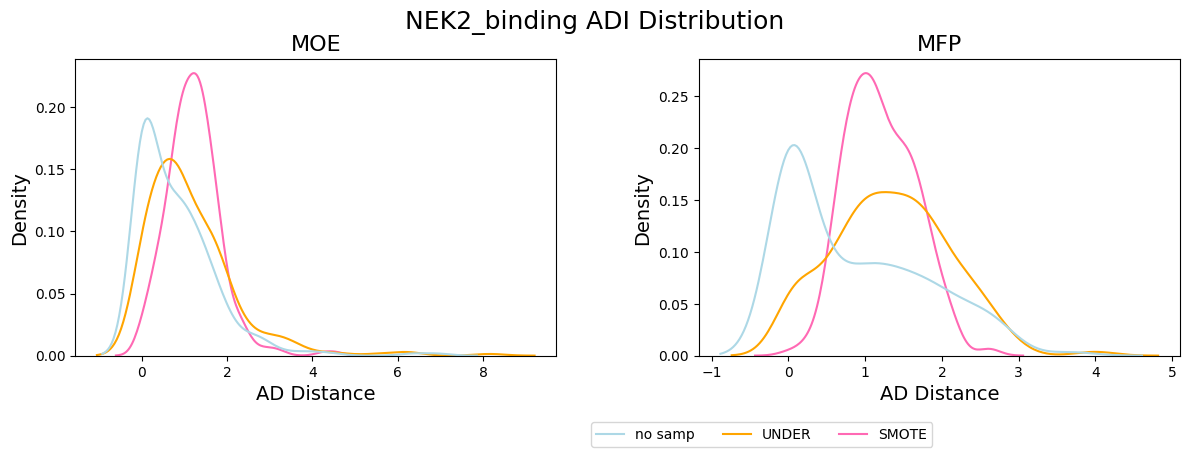

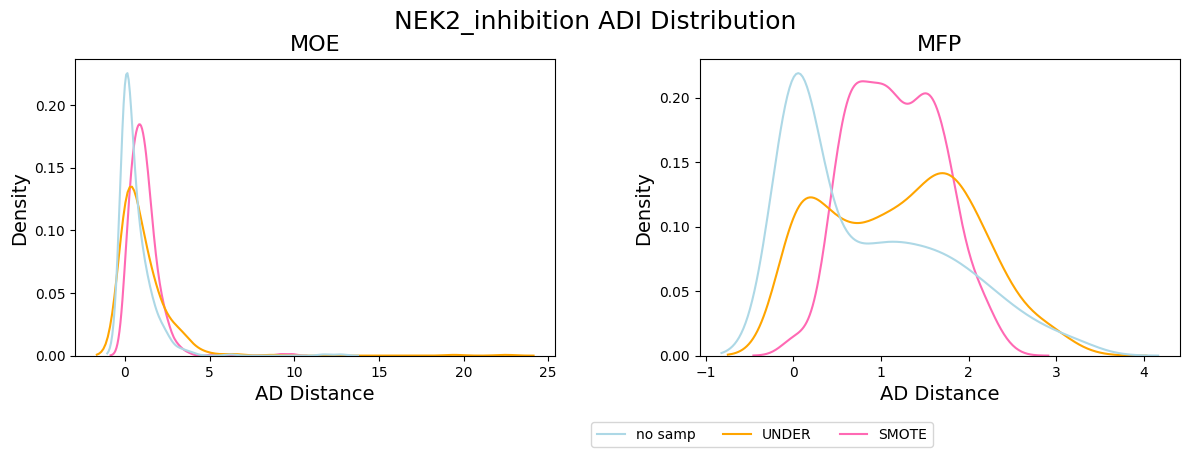

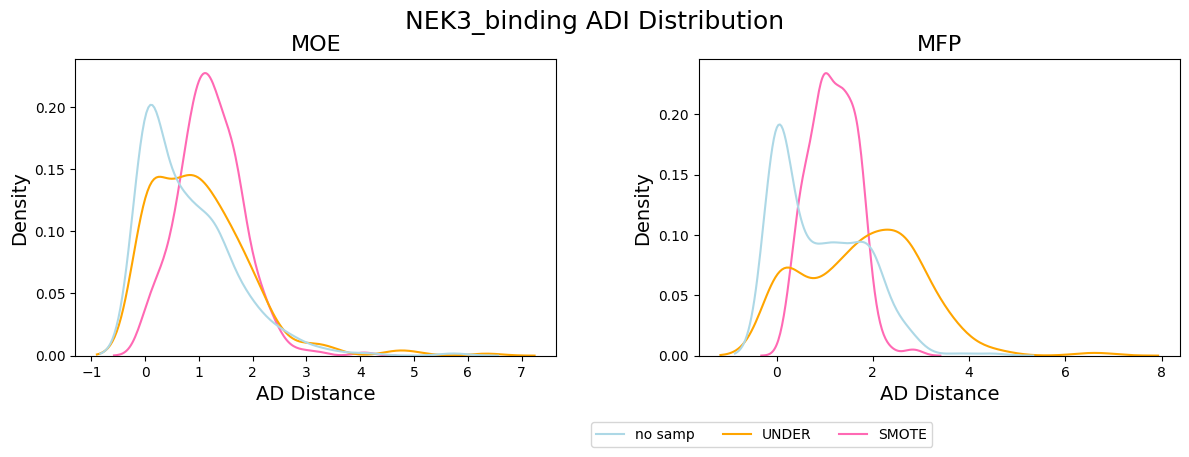

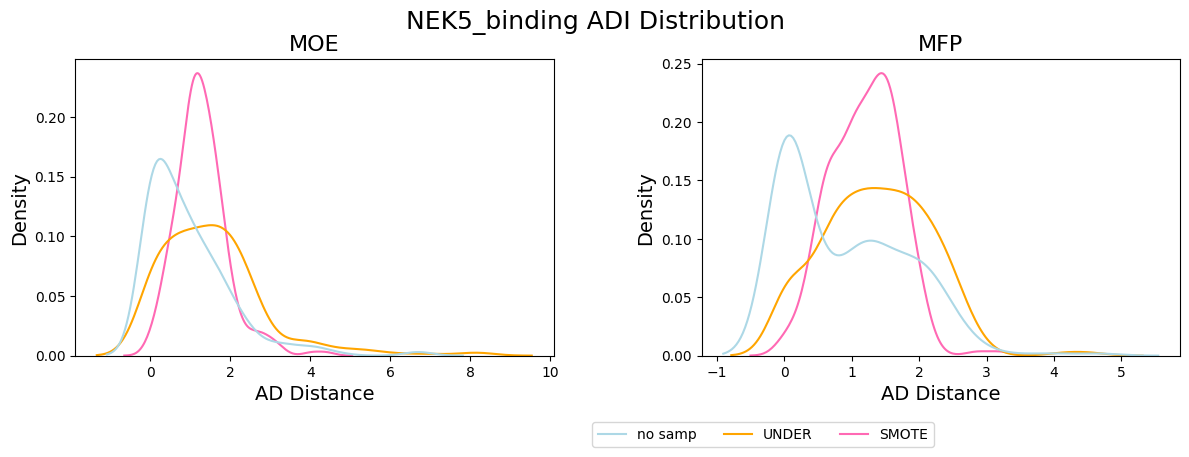

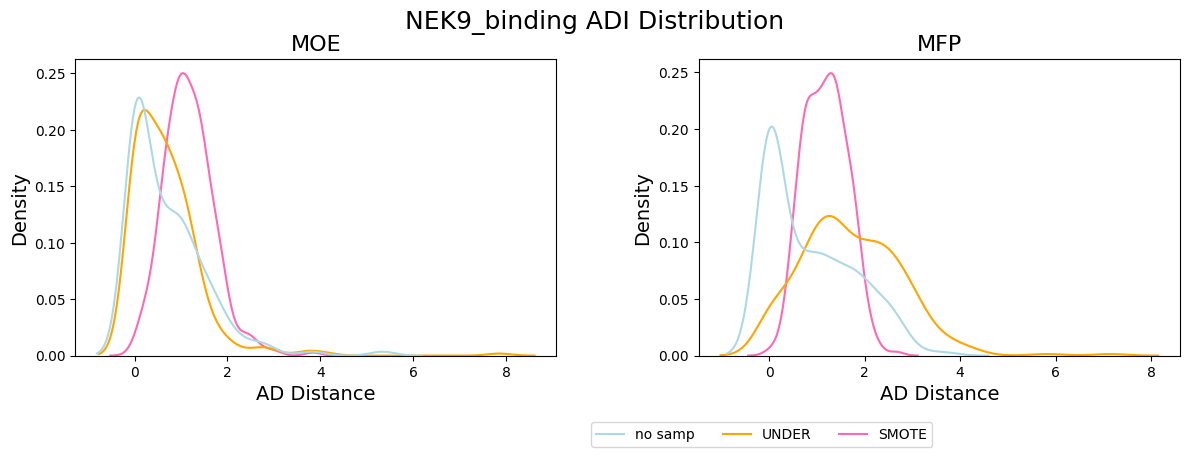

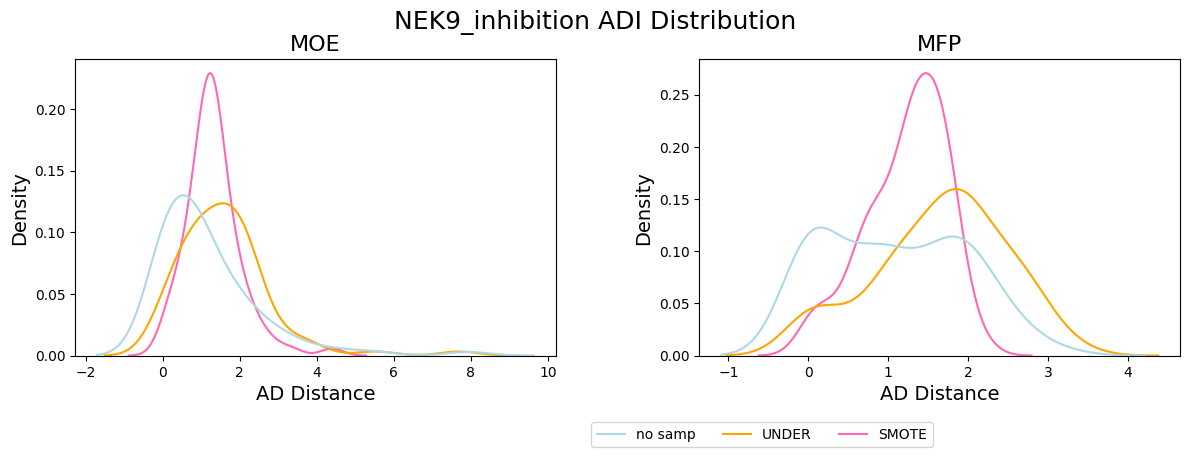

In [122]:
for nek in neks: 
    df = AD_df[AD_df['NEK']==nek]
    df=df[df['strategy']!='ADASYN']
    df_flat = df.explode('ADdist')

    df_flat['ADdist'] = pd.to_numeric(df_flat['ADdist'])
    moe_df = df_flat[df_flat['feat_type'] == 'MOE'] 
    mfp_df = df_flat[df_flat['feat_type'] == 'MFP'] 
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    sns.kdeplot(data=moe_df, x='ADdist', hue='strategy', palette=samp_palette, ax=ax[0],legend=False)
    
    ax[0].set_title(f'MOE',fontsize=16)
    ax[0].set_xlabel('AD Distance', fontsize=14)
    ax[0].set_ylabel('Density', fontsize=14)
  
    sns.kdeplot(data=mfp_df, x='ADdist', hue='strategy', palette=samp_palette,ax=ax[1],legend=False)
    ax[1].set_title(f'MFP',fontsize=16)
    ax[1].set_xlabel('AD Distance', fontsize=14)
    ax[1].set_ylabel('Density', fontsize=14)

    samp_list=list(samp_palette.values())

    # handles = [mlines.Line2D([],[], color=samp_list[i], label=samp_list[i]) for i in range(len(samp_list))]
    # fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.77, -0.008), ncol=4,fontsize=16)

    no_samp_line = Line2D([0],[0], color='lightblue',linestyle='solid', label='no samp')
    UNDER_line = Line2D([0],[0], color='orange',linestyle='solid', label='UNDER')
    SMOTE_line = Line2D([0],[0], color='hotpink',linestyle='solid', label='SMOTE')
    ax[1].legend(handles=[no_samp_line,UNDER_line,SMOTE_line], ncols=3, bbox_to_anchor=(.5, -.2))
    plt.subplots_adjust(wspace=0.1)

    plt.suptitle(f'{nek} ADI Distribution', y=0.94, fontsize=18)
    plt.tight_layout()
    plt.savefig(f'ADI_KDE/{nek}_ADdist_kde.png', bbox_inches='tight')
    plt.show();

In [61]:
samp_list

['orange', 'hotpink', 'lightblue']

In [82]:
handles